# Projekt CFD WS 2016 / 2017


## Advanced Upstream Splitting Method:

$
\frac{\partial}{\partial t}\left(\begin{array}{c}
\rho\\
\rho u\\
e
\end{array}\right)+\frac{\partial}{\partial x}\left(\begin{array}{c}
\rho u\\
\rho u^{2}+p\\
\left(e+p\right)u
\end{array}\right)=-\frac{S_{x}}{S}\left(\begin{array}{c}
\rho u\\
\rho u^{2}\\
\left(e+p\right)u
\end{array}\right)
$

For the AUSM approach the second term is splitted into a convection-term and a term containing the information of acustic wave transport. So these terms can be treated in different way.

$
\mathbf{F}=M\cdot c\left(\begin{array}{c}
\rho\\
\rho u\\
e+p
\end{array}\right)+\left(\begin{array}{c}
0\\
p\\
0
\end{array}\right)=\mathbf{f}^{(c)}+\mathbf{P}
$


The speed of the convection-transport is the local velocity of the fluid $u$. For the 1D-case the direction is given by the sign of $u$. No convection-information can "flow" upstram. This term can be numerical represented by splitting the flux with regard to the local velocity.
The pressure information is send up and down the stream if the velocity is smaller then the local speed of sound c. Thus a central discretization scheme is used to represent the information transport if M < 1. Else the discretization is choosen according to the local velocity.
With AUSM a central differenziation is weighted by the local velocity. According to the weight of upstream and downstream  information is choosen by some polynomials.
These polynomials are functions of the local Mach-number M and a shape-function 
$\alpha$ and $\beta$. The functions are implemented in *AUSM_1D.M_split* and *AUSM_1D.P_split*.

In [1]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 11, 8

In [2]:
class AUSM_1D(object):
    """This class provides methods to solve a 1D nozzle flow problem
       described with the euler-flow-equations.
       AUSM: Advection Upstream Splitting Method"""
    
    # default values for the splitting polynoms
    beta = 1 / 8
    alpha = 3 / 16 * 0.5
    
    @staticmethod
    def M_split(M, sign, beta):
        """13-99""" # splitting polynom for the Mach number
        if abs(M) >= 1:
            return 0.5 * (M + abs(M) * sign)
        else:
            par = sign * beta * (M**2 - 1)**2
            return sign * 0.25 * (M + sign) ** 2 + par

    @staticmethod
    def P_split(M, sign, alpha):
        """13.101""" # splitting polynom for the pressure
        if abs(M) >= 1:
            return 0.5 * (1 + sign * (np.sign(M)))
        else:
            par = sign * alpha * M * (M**2 - 1)**2
            return 0.25 * (M + sign)**2 * (2 - sign * M) + par
        
    @staticmethod
    def lr_split(value):
        """if value >= 0 -> left, else right"""
        return ((value >= 0) * value, (value < 0) * value)

    @staticmethod
    def cellFunc(foo, *args):
        """map foo @ args, args are array of equal lengths"""
        # is needed to map a function at a matrix/ array
        return np.array([foo(*[val[i] for val in args]) 
                                for i in range(len(args[0]))])
        
    def __init__(self, parameter):  # 1
        # entry point for object creation
        self.parameter = parameter
        self.time = 0.
        self._computeGeometry()  # 1.1
        self._initUVector()      # 1.2
    
    def _computeGeometry(self):  # 1.1
        """compute the geometry and derivatives"""
        par = self.parameter
        self.x = np.linspace(par["xmin"], par["xmax"], par["numx"])
        self.S = par["ymin"] + (par["ymax"]-par["ymin"])*(self.x/par["xmax"])**2
        self.dS = 2 * (par["ymax"] - par["ymin"]) * self.x / par["xmax"] ** 2
        self.dx = self.x[1] - self.x[0]
        
    def _initUVector(self):     # 1.2
        """initialize the U-Vector"""
        par = self.parameter
        rho_tot = par["p_tot"] / par["R"] / par["T_tot"]
        self.u = np.array([
            self.vec_1 * rho_tot,                        # u[0]
            self.vec_0,                                  # u[1]
            self.vec_1 * par["p_tot"] / (self.gamma -1)  # u[2]
        ])
    
    def timeStep(self):   # 2.1
        """compute one time-step"""
        max_eigen = max(list(abs(self.u_vel + self.c_wave)) + 
                        list(abs(self.u_vel - self.c_wave)))
        dt = self.parameter["cfl"] * self.dx / max_eigen
        self.time += dt
        self.dt = dt
        return dt

    def compute_c_star(self): # 2.2
        """return an array with len(u - 1)"""
        u_l, u_r = self.lr_split(self.u_vel)
        c_l = self.c_wave**2 / self.cellFunc(max, self.c_wave, abs(u_l))
        c_r = self.c_wave**2 / self.cellFunc(max, self.c_wave, abs(u_r))
        return np.array([min(c_lr) for c_lr in zip(c_l[:-1], c_r[1:])])
    
    def compute_m_star(self, c_star): # 2.3
        M_split_n = np.vectorize(lambda M: AUSM_1D.M_split(M, -1, self.beta))
        M_split_p = np.vectorize(lambda M: AUSM_1D.M_split(M, +1, self.beta))
        M_l = self.u_vel[:-1] / c_star
        M_r = self.u_vel[1:] / c_star
        return M_split_p(M_l) + M_split_n(M_r)
    
    def compute_p_star(self, c_star): # 2.4
        P_split_n = np.vectorize(lambda M: AUSM_1D.P_split(M, -1, self.alpha))
        P_split_p = np.vectorize(lambda M: AUSM_1D.P_split(M, +1, self.alpha))
        M_l = self.u_vel[:-1] / c_star
        M_r = self.u_vel[1:] / c_star
        return P_split_p(M_l) * self.p[:-1] + P_split_n(M_r) * self.p[1:]
    
    def compute_f_star(self, c_star, m_star, p_star): # 2.5
        m_star_p = 0.5 * (m_star + abs(m_star))  # 13.106
        m_star_n = 0.5 * (m_star - abs(m_star))
        f_star = c_star * (m_star_p * self.phi[:,:-1] + m_star_n * self.phi[:,1:])
        return f_star + np.array([self.vec_0[:-1], p_star, self.vec_0[:-1]])
    
    def compute_source(self):   # 2.6
        return self.dS / self.S * (self.u_vel * self.phi)

    def applyBoundaries(self):  # 2.7
        par = self.parameter
        cp = self.gamma / (self.gamma - 1) * par["R"]
        rho_tot = par["p_tot"] / par["R"] / par["T_tot"]
        p_tot = par["p_tot"]

        # in->|.|.|...
        rho = 2 * self.u[0][1] - self.u[0][2]
        if rho > rho_tot:
            rho = rho_tot
        p = p_tot * (par["R"] * par["T_tot"] * rho / p_tot) ** self.gamma
        
        temp = 1 - (p / p_tot) ** ((self.gamma - 1) / self.gamma)
        vel = (2 * cp * par["T_tot"] * temp) ** 0.5
        e = p / (self.gamma - 1) + rho * vel ** 2 / 2
        self.u[0, 0] = rho
        self.u[1, 0] = rho * vel
        self.u[2, 0] = e
    
        # ...|.|.|->out
        p = par["p_exit"]
        rho = 2 * self.u[0][-2] - self.u[0][-3]
        if rho > rho_tot:
            rho = rho_tot
        self.u[0, -1] = rho
        self.u[1, -1] = 2 * self.u[1][-2] - self.u[1][-3]
        self.u[2, -1] = 2 * self.u[2][-2] - self.u[2][-3]
        
        if (par["subsonic_exit"]):
            p = par["p_exit"]
            e = p / (self.gamma - 1) + self.u[1][-1] ** 2 / 2. / rho
            self.u[2][-1] = e

    def makeStep(self):  # 2
        """compute one time step"""
        dt = self.timeStep() # 2.1
        c_star = self.compute_c_star() # 2.2
        m_star = self.compute_m_star(c_star) # 2.3
        p_star = self.compute_p_star(c_star) # 2.4
        f_star = self.compute_f_star(c_star, m_star, p_star) # 2.5
        source = self.compute_source() # 2.6
    
        # Integration of u
        du = -dt / self.dx * (f_star[:,1:] - f_star[:,:-1]) - source[:,1:-1] * dt
        self.u[:,1:-1] += du
        
        self.applyBoundaries() # 2.7
    
    @property
    def gamma(self):
        return self.parameter["kappa"]
    
    @property
    def phi(self):
        """Eq.13.96"""
        return np.array([self.u[0], self.u[1], self.u[0] * self.H])
    
    @property
    def rho(self):
        return self.u[0]
    
    @property
    def p(self):
        return (self.u[2] - self.rho * self.u_vel ** 2 / 2)*(self.gamma - 1)
    
    @property
    def H(self):
        """13.89"""
        return self.u_vel ** 2 / 2 + self.c_wave ** 2/(self.gamma - 1)
    
    @property
    def u_vel(self):
        return self.u[1] / self.rho;
    
    @property
    def c_wave(self):
        return (self.gamma * self.p / self.rho) ** 0.5
    
    @property
    def Mach(self):
        return self.u_vel / self.c_wave
    
    @property
    def vec_1(self):
        """[1, 1, ..., 1, 1]"""
        return np.ones(self.parameter["numx"])
    
    @property
    def vec_0(self):
        """[0, 0, ..., 0, 0]"""
        return np.zeros(self.parameter["numx"])

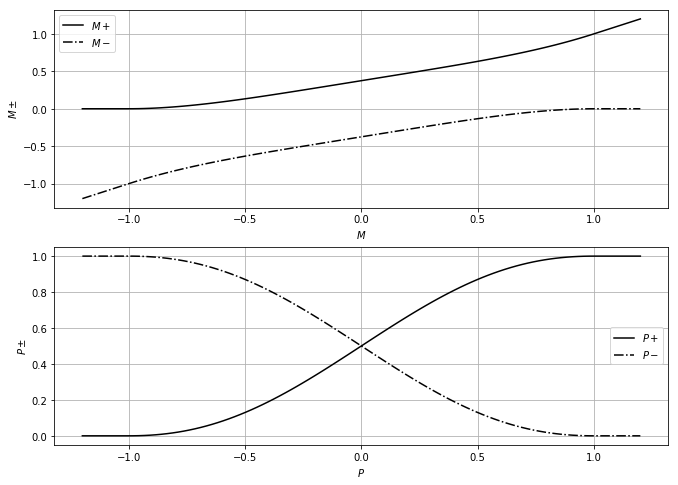

In [3]:
M = np.linspace(-1.2, 1.2, 100)
y1 = [AUSM_1D.M_split(Mi, 1, AUSM_1D.beta) for Mi in M]
y2 = [AUSM_1D.M_split(Mi, -1, AUSM_1D.beta) for Mi in M]

ax1 = plt.subplot(211)
ax1.plot(M, y1, c="0", linestyle="-", label = "$M+$")
ax1.plot(M, y2, c="0", linestyle="-.", label = "$M-$")
ax1.set_ylabel("$M\pm$")
ax1.set_xlabel("$M$")
ax1.grid()
ax1.legend()

ax2 = plt.subplot(212)
y1 = [AUSM_1D.P_split(Mi, 1, AUSM_1D.alpha) for Mi in M]
y2 = [AUSM_1D.P_split(Mi, -1, AUSM_1D.alpha) for Mi in M]
ax2.plot(M, y1, c="0", linestyle="-", label = "$P+$")
ax2.plot(M, y2, c="0", linestyle="-.", label = "$P-$")
ax2.set_ylabel("$P\pm$")
ax2.set_xlabel("$P$")
ax2.grid()
ax2.legend()
plt.show()

In [4]:
par = {"R": 287.0,  "kappa": 1.4,    "p_tot": 1.0e5, "T_tot": 273.15,
       "cfl": 0.9,  "p_exit": 0.8e5, "xmin": -1.,    "xmax": 1.,
       "numx": 200, "ymin": 0.2,    "ymax": 0.3,    "subsonic_exit": True}


nozzle = AUSM_1D(par)    # 1: create a AUSM_1D object + initialize
for i in range(5000):
    nozzle.makeStep()    # 2: make 10000 steps

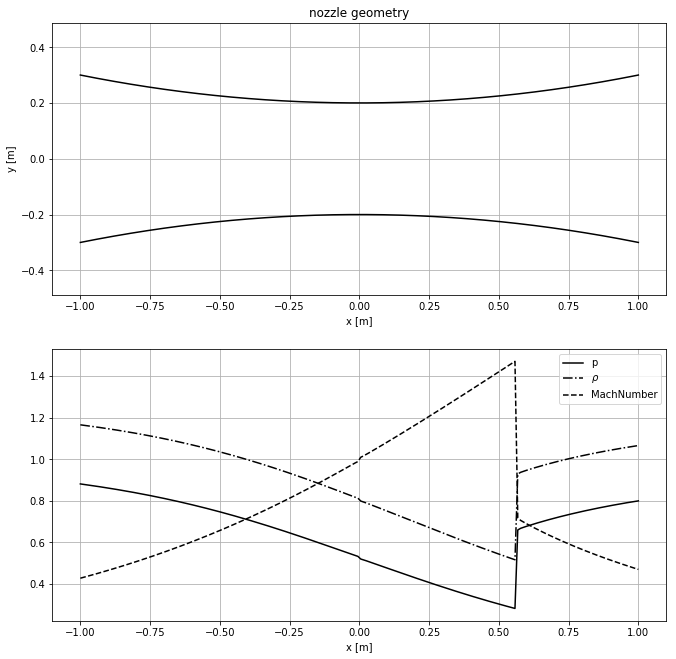

In [5]:
plt.figure(figsize=(11,11))
ax1 = plt.subplot(211)
ax1.set_title("nozzle geometry")
ax1.plot(nozzle.x, np.array([nozzle.S, -nozzle.S]).T, c="0")
ax1.grid()
ax1.set_aspect(1)
ax1.set_xlabel("x [m]")
ax1.set_ylabel("y [m]")

ax2 = plt.subplot(212, sharex=ax1)
ax2.plot(nozzle.x, nozzle.p *1e-5, c="0", linestyle="-", label="p")
ax2.plot(nozzle.x, nozzle.rho, c="0", linestyle="-.", label=r"$\rho$")
ax2.plot(nozzle.x, nozzle.Mach, c="0", linestyle="--", label="MachNumber")
ax2.grid()
ax2.legend()
ax2.set_xlabel("x [m]")

plt.show()

In [6]:
class AUSM_ShockTube(AUSM_1D):
    """the same class as AUSM_1D but with special treatment of boundaries
       and initialization"""
    def _initUVector(self):
        par = self.parameter
        p_1 = par["p_1"]
        p_2 = par["p_2"]
        rho_1 = par["rho_1"]
        rho_2 = par["rho_2"]
        u_1 = np.array([
            self.vec_1 * rho_1,                 # u[0]
            self.vec_0,                         # u[1]
            self.vec_1 * p_1 / (self.gamma -1)  # u[2]
        ])
        u_2 = np.array([
            self.vec_1 * rho_2,                 # u[0]
            self.vec_0,                         # u[1]
            self.vec_1 * p_2 / (self.gamma -1)  # u[2]
        ])
        mult_vec = self.vec_0
        for i in range(par["numx"]//2):
            mult_vec[i] += 1
        self.u = u_1 * mult_vec - u_2 * (mult_vec - 1)
        
    def applyBoundaries(self):
        """overwrite, boundaries have no influence"""
        pass

In [7]:
class ShockTube(object):
    """analytic solution to the shock-tube problem"""
    @staticmethod
    def shock_tube_function(p4, p1, p5, rho1, rho5, gamma):
        z = (p4 / p5 - 1.)
        c1 = np.sqrt(gamma * p1 / rho1)
        c5 = np.sqrt(gamma * p5 / rho5)
        gm1 = gamma - 1.
        gp1 = gamma + 1.
        g2 = 2. * gamma
        fact = gm1 / g2 * (c5 / c1) * z / np.sqrt(1. + gp1 / g2 * z)
        fact = (1. - fact) ** (g2 / gm1)
        return p1 * fact - p4

    def __init__(self, p_1, p_5, rho_1, rho_5, gamma=1.4):
        self.gamma = gamma
        self.p_1 = p_1
        self.p_5 = p_5
        self.rho_1 = rho_1
        self.rho_5 = rho_5
        self.u_1 = 0
        self.u_5 = 0
        self.p_4 = scipy.optimize.fsolve(self.shock_tube_function, self.p_1, 
                   (self.p_1, self.p_5, self.rho_1, self.rho_5, self.gamma))[0]
        z = (self.p_4 / self.p_5 - 1.)
        c5 = np.sqrt(gamma * self.p_5 / self.rho_5)

        gm1 = self.gamma - 1.
        gp1 = self.gamma + 1.
        gmfac1 = 0.5 * gm1 / self.gamma
        gmfac2 = 0.5 * gp1 / self.gamma
        fact = np.sqrt(1. + gmfac2 * z)
        self.u_4 = c5 * z / (self.gamma * fact)
        self.rho_4 = self.rho_5 * (1. + gmfac2 * z) / (1. + gmfac1 * z)

        # shock speed
        self.w = c5 * fact
        
        self.p_3 = self.p_4
        self.u_3 = self.u_4
        self.rho_3 = self.rho_1 * (self.p_3 / self.p_1)**(1. / self.gamma)
    
    def get_positions(self, t):
        c1 = np.sqrt(self.gamma * self.p_1 / self.rho_1)
        c3 = np.sqrt(self.gamma * self.p_3 / self.rho_3)
        return np.array([- c1 * t, (self.u_3 - c3) * t, self.u_3 * t, self.w * t ,])
    
    def get_points(self, t, num_points=10):
        jump = 10e-10
        c1 = np.sqrt(self.gamma * self.p_1 / self.rho_1)
        c5 = np.sqrt(self.gamma * self.p_5 / self.rho_5)
        gm1 = self.gamma - 1.
        gp1 = self.gamma + 1.
        pos = self.get_positions(t)
        x_pos_1_2 = np.linspace(pos[0], pos[1], num_points)
        x_min = pos[0] - (pos[-1] - pos[0]) * 0.4
        x_max = pos[-1] + (pos[-1] - pos[0]) * 0.4

        u_1_2 = 2. / gp1 * (c1 + x_pos_1_2 / t)
        fact = 1. - 0.5 * gm1 * u_1_2 / c1
        rho_1_2 = self.rho_1 * fact ** (2. / gm1)
        p_1_2 = self.p_1 * fact ** (2. * self.gamma / gm1)

        x_values = np.array([x_min] + list(x_pos_1_2) + 
                            [pos[2], pos[2] + jump, pos[3], pos[3] + jump, x_max])
        p_values = np.array([self.p_1] + list(p_1_2) +
                            [self.p_3, self.p_4, self.p_4, self.p_5, self.p_5])
        u_values = np.array([self.u_1] + list(u_1_2) +
                            [self.u_3, self.u_4, self.u_4, self.u_5, self.u_5])
        rho_values = np.array([self.rho_1] + list(rho_1_2) +
                            [self.rho_3, self.rho_4, self.rho_4, 
                             self.rho_5, self.rho_5])
        return x_values, p_values, rho_values, u_values, x_min, x_max

In [8]:
par = {"R": 287.0,  "kappa": 1.4,   "p_1": 1.0,  "p_2": 0.1,
       "rho_1": 1,  "rho_2": 0.125, "cfl": 0.1,  "xmin": -1.,
       "xmax": 1.,  "numx": 70,     "ymin": 1,   "ymax": 1.}

numeric_tube = AUSM_ShockTube(par)
for i in range(300):
    numeric_tube.makeStep()

analytic_tube = ShockTube(par["p_1"], par["p_2"], par["rho_1"], par["rho_2"])
x, p, rho, u, x_min, x_max = analytic_tube.get_points(numeric_tube.time)

plotting at time = 0.412238689802 s


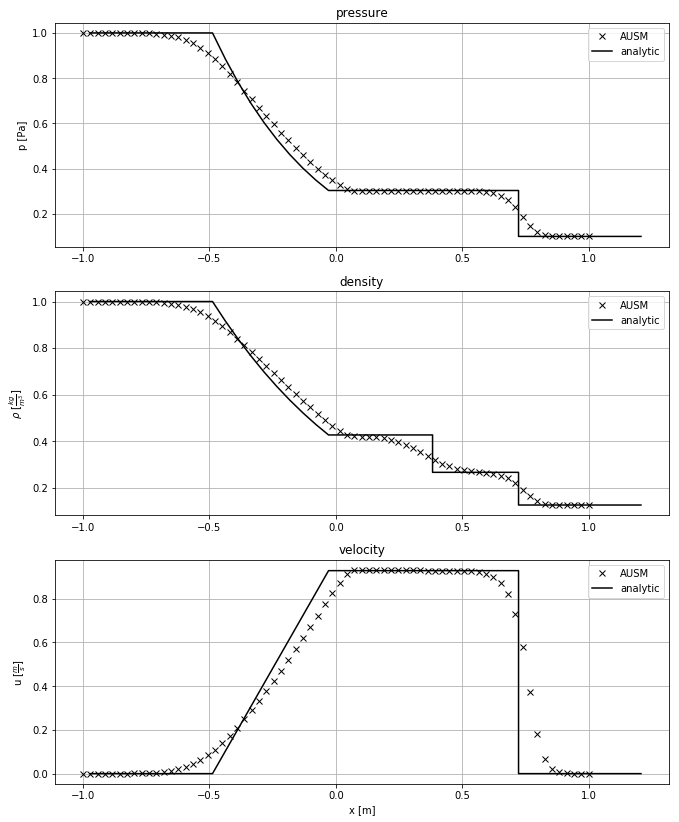

In [9]:
print("plotting at time = " + str(numeric_tube.time) + " s")
plt.figure(figsize=(11,14))
ax1 = plt.subplot(311)
ax1.set_title('pressure')
ax1.plot(numeric_tube.x, numeric_tube.p, label='AUSM', c="0", 
         linestyle="", marker="x")
ax1.plot(x, p, linewidth=1.5, color='0', label='analytic')
ax1.legend()
ax1.set_ylabel("p [Pa]")
ax1.grid()

ax2 = plt.subplot(312)
ax2.set_title('density')
ax2.plot(numeric_tube.x, numeric_tube.rho, label='AUSM', c="0", 
         linestyle="", marker="x")
ax2.plot(x, rho, linewidth=1.5, color='0', label=r'analytic')
ax2.legend()
ax2.set_ylabel(r"$\rho$ $[\frac{kg}{m^3}]$")
ax2.grid()

ax3 = plt.subplot(313)
ax3.set_title('velocity')
ax3.plot(numeric_tube.x, numeric_tube.u_vel, label='AUSM', c="0", 
         linestyle="", marker="x")
ax3.plot(x, u, linewidth=1.5, color='0', label=r'analytic')
ax3.set_ylabel(r"u $[\frac{m}{s}]$")
ax3.legend()

ax3.set_xlabel("x [m]")
ax3.grid()

plt.show()